In [2]:
import pickle
import sys
sys.path.extend(['C:\\git\\thesis_clean_v2'])
from OriKerasExtension.ThesisHelper import readCompleteMatFile, ExtractDataVer4
from experiments.pretrained_by_colors.color_utils import create_color_dictionary, get_color_from_stimuli
from keras.utils.np_utils import to_categorical
from scipy import stats


In [3]:

results_train_per_subject = pickle.load(  open( r"C:\git\thesis_clean_v2\experiments\pretrained_by_colors\save_25_april_predict_color_take_3.p", "rb" ) )
results_train_all_except_test = pickle.load(  open( r"C:\git\thesis_clean_v2\experiments\pretrained_by_colors\save_28_april_predict_color_all_subjects_aggregated_except_one.p", "rb" ) )
results_train__all_except_test_and_then_find_tune = pickle.load(  open( r"C:\git\thesis_clean_v2\experiments\pretrained_by_colors\save_13_may_predict_color_all_subjects_except_one_and_fine_tune.p", "rb" ) )

In [4]:
data_set_locations_116 = ["RSVP_Color116msVPicr.mat",
                          "RSVP_Color116msVPpia.mat",
                          "RSVP_Color116msVPfat.mat",
                          "RSVP_Color116msVPgcb.mat",
                          "RSVP_Color116msVPgcc.mat",
                          "RSVP_Color116msVPgcd.mat",
                          "RSVP_Color116msVPgcf.mat",
                          "RSVP_Color116msVPgcg.mat",
                          "RSVP_Color116msVPgch.mat",
                          "RSVP_Color116msVPiay.mat",
                          "RSVP_Color116msVPicn.mat"];

for i, subject_name in enumerate(data_set_locations_116):
    subject_data = next(x for x in results_train_per_subject )
    print subject_data.keys()
    break

['lstm_history', 'subject_name', 'mlp_history']


In [5]:
len(results_train_per_subject)
print results_train_per_subject[0].keys()

['lstm_history', 'subject_name', 'mlp_history']


In [6]:



def downsample_data(data, number_of_original_samples, down_samples_param):
    new_number_of_time_stamps = number_of_original_samples / down_samples_param

    temp_data_for_eval = np.zeros((data.shape[0], new_number_of_time_stamps, data.shape[2]))

    for new_i, i in enumerate(range(0, number_of_original_samples, down_samples_param)):
        temp_data_for_eval[:, new_i, :] = np.mean(data[:, range(i, (i + down_samples_param)), :], axis=1)
    return temp_data_for_eval

def create_letter_test_data_color(gcd_res, down_samples_param, jitter=20):
    last_time_stamp = 800 + jitter
    fist_time_stamp = -200 +jitter
    color_dictionary = create_color_dictionary()
    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'],
                                    gcd_res['target'], fist_time_stamp, last_time_stamp)

    print data_for_eval[0].shape
    temp_data_for_eval = downsample_data(data_for_eval[0], data_for_eval[0].shape[1], down_samples_param)

    all_data = temp_data_for_eval[np.all([gcd_res['train_mode'] == 3], axis=0)]

    categorical_tags = to_categorical(
        get_color_from_stimuli(gcd_res['stimulus'][gcd_res['train_mode'] == 3], color_dictionary))
    shuffeled_samples, suffule_tags = (all_data, categorical_tags)
    return shuffeled_samples, suffule_tags

In [7]:
from keras.layers import Convolution2D, Activation, MaxPooling2D, Flatten, Dense, LSTM, Dropout
from keras.models import Sequential
from keras.regularizers import l2



Using Theano backend.
Using gpu device 0: GeForce GT 740M (CNMeM is disabled, CuDNN not available)
DEBUG: nvcc STDOUT mod.cu
   Creating library c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmp1aiini/97496c4d3cf9a06dc4082cc141f918d2.lib and object c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmp1aiini/97496c4d3cf9a06dc4082cc141f918d2.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmpofkdho/6174b19f8005a60d6a2faaae7ff1c9a7.lib and object c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmpofkdho/6174b19f8005a60d6a2faaae7ff1c9a7.exp

C:\Anaconda\lib\site-packages\theano\tensor\signal\downsample.py:5: UserWarning: downsample module has been moved to the pool module.

In [8]:
"""
define the neural network model:
"""
model_lstm = Sequential()

model_lstm.add(LSTM(input_dim=55, output_dim=20, return_sequences=True))
model_lstm.add(Dropout(0.01))
model_lstm.add(LSTM(input_dim=20, output_dim=20, return_sequences=False))
#     model_lstm.add(Dropout(0.01))
#     model_lstm.add(LSTM(input_dim=20, output_dim=20,return_sequences=False))
model_lstm.add(Dense(5, W_regularizer=l2(0.006)))
model_lstm.add(Activation('softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop',)



DEBUG: nvcc STDOUT mod.cu
   Creating library c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmphkuerd/da6ac6908198a9d83223e8a2be6b76b9.lib and object c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmphkuerd/da6ac6908198a9d83223e8a2be6b76b9.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmp97vtxu/fb5bc112d1778d5cf2ea21dbb43e7346.lib and object c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmp97vtxu/fb5bc112d1778d5cf2ea21dbb43e7346.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmpviazma/8e7b50a8223127f83423bdce68ed1923.lib and object c:/tmp/thean

In [9]:
import keras
"""
define the neural network model:
"""
model_mpl = Sequential()
model_mpl.add(keras.layers.core.Flatten(input_shape=(55, 25)))
model_mpl.add(Dense(input_dim=55 * 25, output_dim=20))
model_mpl.add(Dropout(0.3))
model_mpl.add(Activation('tanh'))
model_mpl.add(Dense(output_dim=20, W_regularizer=l2(0.06)))
model_mpl.add(Activation('tanh'))
model_mpl.add(Dense(5))
model_mpl.add(Activation('softmax'))
model_mpl.compile(loss='categorical_crossentropy', optimizer='rmsprop')

DEBUG: nvcc STDOUT mod.cu
   Creating library c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmpsjsgco/9854bfa6f034fe0d8f1c2131d4045172.lib and object c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmpsjsgco/9854bfa6f034fe0d8f1c2131d4045172.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmpbqc5ar/03591e6f7304156e3b956ee04cd01af3.lib and object c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmpbqc5ar/03591e6f7304156e3b956ee04cd01af3.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library c:/tmp/theano.NOBACKUP/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.11-64/tmp6akkps/1f77676baa319f8544e1429675dadf3e.lib and object c:/tmp/thean

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline 
# print results[0]['lstm_history']['val_accuracies'][-1]
# print results[0]['mlp_history']['val_accuracies'][-1]
# print results[0]['mlp_history'].keys()
# plt.plot(results[0]['lstm_history']['train_accuracies'])
# plt.plot(results[0]['lstm_history']['val_accuracies'])
# plt.show()

# plt.plot(results[0]['lstm_history']['train_losses'])
# plt.plot(results[0]['lstm_history']['val_losses'])
# plt.show()


# plt.plot(results[0]['mlp_history']['train_accuracies'])
# plt.plot(results[0]['mlp_history']['val_accuracies'])
# plt.show()

# plt.plot(results[0]['mlp_history']['train_losses'])
# plt.plot(results[0]['mlp_history']['val_losses'])
# plt.show()


In [33]:
import numpy as np
def calculate_accuracy(result_data, jitter=0):

    data_set_locations = ["RSVP_Color83msVPicr.mat",
                          "RSVP_Color83msVPpia.mat",
                          "RSVP_Color83msVPfat.mat",
                          "RSVP_Color83msVPgcb.mat",
                          "RSVP_Color83msVPgcc.mat",
                          "RSVP_Color83msVPgcd.mat",
                          "RSVP_Color83msVPgcf.mat",
                          "RSVP_Color83msVPgcg.mat",
                          "RSVP_Color83msVPgch.mat",
                          "RSVP_Color83msVPiay.mat",
                          "RSVP_Color83msVPicn.mat"];


    data_set_locations_116 = ["RSVP_Color116msVPicr.mat",
                          "RSVP_Color116msVPpia.mat",
                          "RSVP_Color116msVPfat.mat",
                          "RSVP_Color116msVPgcb.mat",
                          "RSVP_Color116msVPgcc.mat",
                          "RSVP_Color116msVPgcd.mat",
                          "RSVP_Color116msVPgcf.mat",
                          "RSVP_Color116msVPgcg.mat",
                          "RSVP_Color116msVPgch.mat",
                          "RSVP_Color116msVPiay.mat",
                          "RSVP_Color116msVPicn.mat"];

    lstm_accuracy = []
    mlp_accuracy = []

    for i, subject_name in enumerate(data_set_locations_116):
        try:
            subject_data = next(x for x in result_data if x[0]['subject_name'] == subject_name)[0]
        except:
            subject_data = next(x for x in result_data if x['subject_name'] == subject_name)
            
        print (subject_data['subject_name'])

        model_lstm.set_weights(subject_data['lstm_history']['weights'])
        model_mpl.set_weights(subject_data['mlp_history']['weights'])
        file_name = r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format(subject_name)
        gcd_res = readCompleteMatFile(file_name)
        
    #     for jitter in range(-50,50,25):
        single_subject_test_data, single_subject_test_tags = create_letter_test_data_color(gcd_res, down_samples_param=8,jitter=jitter)

        lstm_eval_res = model_lstm.evaluate(stats.zscore(single_subject_test_data, axis=1),single_subject_test_tags, show_accuracy=True)
        mlp_eval_res = model_mpl.evaluate(stats.zscore(single_subject_test_data, axis=1),single_subject_test_tags, show_accuracy=True)
        print lstm_eval_res
        print mlp_eval_res
        lstm_accuracy.append([subject_name,lstm_eval_res[1]])
        mlp_accuracy.append([subject_name,mlp_eval_res[1]])
    return lstm_accuracy, mlp_accuracy
    


In [54]:
# lstm_accuracy_1, mlp_accuracy_1 = calculate_accuracy(results_train_per_subject)
# lstm_accuracy_2, mlp_accuracy_2 = calculate_accuracy(results_train_all_except_test)
# lstm_accuracy_3, mlp_accuracy_3 = calculate_accuracy(results_train__all_except_test_and_then_find_tune)


# lstm_accuracy_1_j, mlp_accuracy_1_j = calculate_accuracy(results_train_per_subject,jitter=20)
# lstm_accuracy_2_j, mlp_accuracy_2_j = calculate_accuracy(results_train_all_except_test,jitter=20)
# lstm_accuracy_3_j, mlp_accuracy_3_j = calculate_accuracy(results_train__all_except_test_and_then_find_tune,jitter=20)
lstm_accuracy_3_jj, mlp_accuracy_3_jj = calculate_accuracy(results_train__all_except_test_and_then_find_tune,jitter=15)



RSVP_Color116msVPicr.mat
(18600L, 200L, 55L)
5400/5400 [==============================] - 0s     
[0.54432319014160724, 0.84685185185185186]
[0.51732199532014356, 0.84259259259259256]
RSVP_Color116msVPpia.mat
(20700L, 200L, 55L)
7500/7500 [==============================] - 0s     
[0.21019240365028383, 0.93973333333333331]
[0.37036672979990642, 0.89653333333333329]
RSVP_Color116msVPfat.mat
(18600L, 200L, 55L)
5400/5400 [==============================] - 0s     
[0.27445731904771592, 0.9194444444444444]
[0.53466212749481201, 0.85018518518518515]
RSVP_Color116msVPgcb.mat
(19500L, 200L, 55L)
6300/6300 [==============================] - 0s     
[0.16698163583165124, 0.95523809523809522]
[0.25405162169819784, 0.91507936507936505]
RSVP_Color116msVPgcc.mat
(18300L, 200L, 55L)
5100/5100 [==============================] - 0s     
[0.24901652978915795, 0.93000000000000005]
[0.33803871720444922, 0.89333333333333331]
RSVP_Color116msVPgcd.mat
(21000L, 200L, 55L)
7800/7800 [=========================

In [110]:
def plot_accuracies(lstm_accuracy_1, mlp_accuracy_1, lstm_accuracy_2, mlp_accuracy_2, lstm_accuracy_3, mlp_accuracy_3, 
                    names=['LSTM-train per subject', 
                           'MLP-train per subject',
                           'LSTM-all exclude one subject',
                           'MLP-all exclude one subject',
                           'LSTM-all and fine tune', 
                           'MLP-all and fine tune'], loc=3):
    fig, ax = plt.subplots()
    fig.set_size_inches(15,6)
    ind = np.arange(len(lstm_accuracy_1))*11
    width = 1


    lstm_accuracies_1 = [x[1]for x in lstm_accuracy_1]
    mlp_accuracies_1 =  [x[1]for x in mlp_accuracy_1]

    lstm_accuracies_2 = [x[1]for x in lstm_accuracy_2]
    mlp_accuracies_2 =  [x[1]for x in mlp_accuracy_2]

    lstm_accuracies_3 = [x[1]for x in lstm_accuracy_3]
    mlp_accuracies_3 =  [x[1]for x in mlp_accuracy_3]

    aggregation_location = 11.5

    lstm_per_subject = ax.bar(ind,lstm_accuracies_1,width,color='r')
    mlp_per_subject = ax.bar(ind + width,mlp_accuracies_1,width,color='g')

    lstm_all_except_one = ax.bar(ind+ width*2 + 1,lstm_accuracies_2,width,color='r',edgecolor='black', hatch="//")
    mlp_all_except_one = ax.bar(ind + width*3+ 1,mlp_accuracies_2,width,color='g',edgecolor='black', hatch="//")

    lstm_all_and_fine_tune = ax.bar(ind+ width*4+ 2,lstm_accuracies_3,width,color='r',edgecolor='black', hatch="--")
    mlp_all_and_fine_tune = ax.bar(ind + width*5+2,mlp_accuracies_3,width,color='g',edgecolor='black', hatch="--")




    #---------------
    mean_results_location = 125
    lstm_per_subject_agg = ax.bar(mean_results_location, np.mean(lstm_accuracies_1), width,yerr=np.std(lstm_accuracies_1),color='r')
    mlp_per_subject_agg = ax.bar(mean_results_location + width, np.mean(mlp_accuracies_1),width,yerr=np.std(mlp_accuracies_1), color='g')

    lstm_all_except_one_agg = ax.bar(mean_results_location + width*2 + 1, np.mean(lstm_accuracies_2),width,yerr=np.std(lstm_accuracies_2),color='r',edgecolor='black', hatch="//")
    mlp_all_except_one_agg = ax.bar(mean_results_location + width*3+ 1, np.mean(mlp_accuracies_2),width,yerr=np.std(mlp_accuracies_2),color='g',edgecolor='black', hatch="//")

    lstm_all_and_fine_tune_agg = ax.bar(mean_results_location+ width*4+ 2,np.mean(lstm_accuracies_3),width,yerr=np.std(lstm_accuracies_3),color='r',edgecolor='black', hatch="--")
    mlp_all_and_fine_tune_agg = ax.bar(mean_results_location + width*5+2,np.mean(mlp_accuracies_3),width,yerr=np.std(mlp_accuracies_3),color='g',edgecolor='black', hatch="--")

    #---------------

    ax.set_xticklabels([x[0][-7:-4] for x in lstm_accuracy_1]+['mean'])
    ind = np.asarray(list(ind) + list([mean_results_location])) +  width*5
    print  ind
    ax.set_xticks(ind  )

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 


    ax.yaxis.grid()
    # ax.set_xticks([13])
    # ax.set_xticklabels()


    ax.legend((lstm_per_subject[0], mlp_per_subject[0],lstm_all_except_one[0],mlp_all_except_one[0],lstm_all_except_one[0],mlp_all_except_one[0]), 
              names, bbox_to_anchor=(1, 1.3))
#     plt.savefig(r"c:\temp\image1.pdf")
    plt.show()


[  5  16  27  38  49  60  71  82  93 104 115 130]


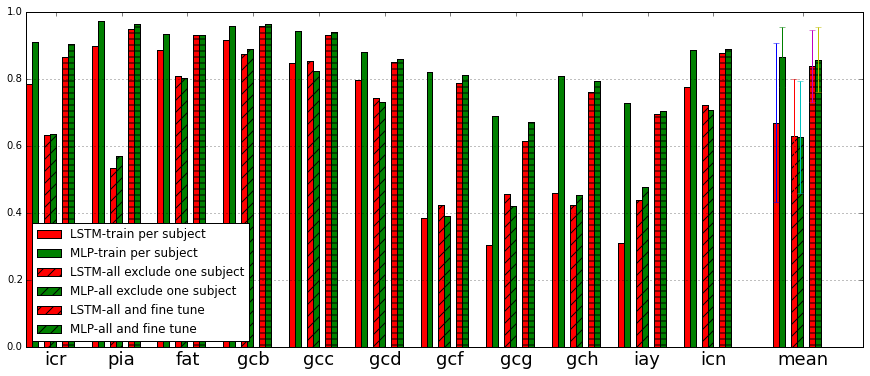

[  5  16  27  38  49  60  71  82  93 104 115 130]


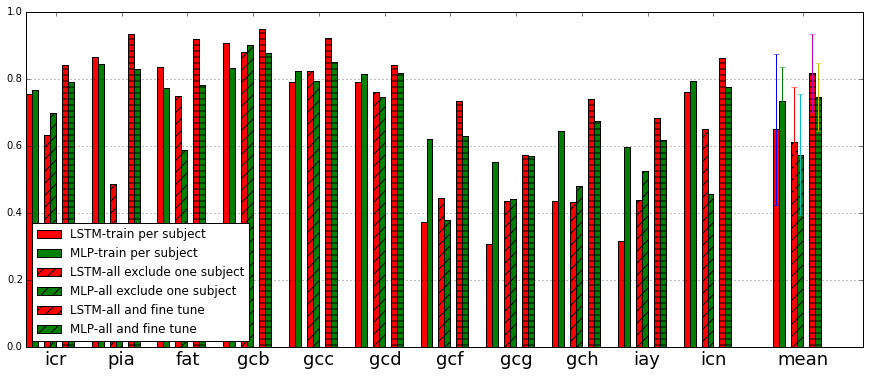

In [36]:
plot_accuracies(lstm_accuracy_1, mlp_accuracy_1, lstm_accuracy_2, mlp_accuracy_2, lstm_accuracy_3, mlp_accuracy_3, 
                    names=['LSTM-train per subject', 
                           'MLP-train per subject',
                           'LSTM-all exclude one subject',
                           'MLP-all exclude one subject',
                           'LSTM-all and fine tune', 
                           'MLP-all and fine tune'])
plot_accuracies(lstm_accuracy_1_j, mlp_accuracy_1_j, lstm_accuracy_2_j, mlp_accuracy_2_j, lstm_accuracy_3_j, mlp_accuracy_3_j,  
                    names=['LSTM-train per subject', 
                           'MLP-train per subject',
                           'LSTM-all exclude one subject',
                           'MLP-all exclude one subject',
                           'LSTM-all and fine tune', 
                           'MLP-all and fine tune'])

import pandas as pd

In [ ]:
pd.DataFrame()

[x[1]for x in mlp_accuracy]+ [np.mean([x[1]for x in mlp_accuracy])]
[x[1]for x in lstm_accuracy]+ [np.mean([x[1]for x in lstm_accuracy])]

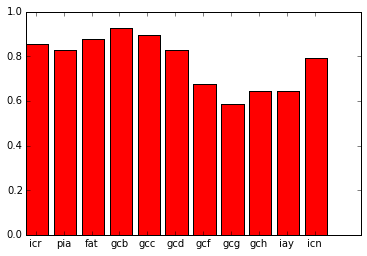

In [21]:
fig, ax = plt.subplots()
rects1 = ax.bar(ind,[x[1]for x in mlp_accuracy],color='r')
ax.set_xticks(ind + width)
ax.set_xticklabels([x[0][-7:-4] for x in lstm_accuracy])
plt.show()

In [14]:
# results.keys()
next(x for x in results if x[0]['subject_name'] == "RSVP_Color116msVPgcb.mat")

[{'lstm_history': {'train_accuracies': [0.22557575757575757,
    0.26865151515151514,
    0.32160606060606062,
    0.50275757575757574,
    0.66727272727272724,
    0.72959090909090907,
    0.76686363636363641,
    0.79045454545454541,
    0.80825757575757573,
    0.82245454545454544,
    0.83703030303030301,
    0.84843939393939394,
    0.85777272727272724,
    0.86621212121212121,
    0.87181818181818183,
    0.87718181818181817,
    0.88066666666666671,
    0.88592424242424239,
    0.88986363636363641,
    0.89206060606060611],
   'train_losses': [1.6302292354468144,
    1.5881846080837827,
    1.5465426515232432,
    1.3045937766161833,
    0.97585655232631796,
    0.82720391023520268,
    0.73924021905841253,
    0.68020024533705281,
    0.63140793959299724,
    0.59175830612760605,
    0.55380335989865392,
    0.51947056215459653,
    0.49248187001546223,
    0.46976819987730545,
    0.45139434753764757,
    0.43582851322491961,
    0.42456563750180332,
    0.41225432812083851,
 

In [38]:
all_data_as_matrix = [lstm_accuracies_1,lstm_accuracies_2, lstm_accuracies_3 , mlp_accuracies_1, mlp_accuracies_2, mlp_accuracies_3]


In [41]:
all_data_as_matrix[0],all_data_as_matrix[4],

([0.78629629629629627,
  0.89826666666666666,
  0.88574074074074072,
  0.91698412698412701,
  0.84745098039215683,
  0.79820512820512823,
  0.38574074074074072,
  0.30320512820512818,
  0.45819444444444446,
  0.31133333333333335,
  0.77700000000000002],
 [0.63518518518518519,
  0.56986666666666663,
  0.80166666666666664,
  0.8887301587301587,
  0.82235294117647062,
  0.73064102564102562,
  0.38981481481481484,
  0.4219230769230769,
  0.4538888888888889,
  0.47716666666666668,
  0.70833333333333337])

In [64]:
np.asarray(all_data_as_matrix).shape

(6L, 11L)

In [70]:
import pyperclip



import pandas as pd
pd.set_option('precision', 2)
names = [x[0][-7:-4] for x in lstm_accuracy_1]
text = pd.DataFrame(data=np.asarray(all_data_as_matrix), columns=names).to_latex()
pyperclip.copy(text)

In [15]:
mean_results_location = 125
np.mean(lstm_accuracies_1), np.mean(lstm_accuracies_2), np.mean(lstm_accuracies_3), np.mean(mlp_accuracies_1), np.mean(mlp_accuracies_2), np.mean(mlp_accuracies_3)


(0.66985614418261485,
 0.62836880603057077,
 0.83869402982638297,
 0.86610496584026009,
 0.62723358406299567,
 0.85795093076857787)

In [42]:
rvs1 = stats.norm.rvs(loc=5,scale=10,size=500)
rvs2 = stats.norm.rvs(loc=5,scale=10,size=500)

In [45]:
rvs1.shape,rvs2.shape

((500L,), (500L,))

In [62]:
lstm_ft = list([x[1] for x in lstm_accuracy_3_j]) + list([x[1] for x in lstm_accuracy_3_jj])
mlp_ft = list([x[1] for x in mlp_accuracy_3_j]) + list([x[1] for x in mlp_accuracy_3_jj])

In [81]:
def mock_2_tuple(names,array):
    return [[x,y] for x,y in zip(names,array)]

[  5  16  27  38  49  60  71  82  93 104 115 130]


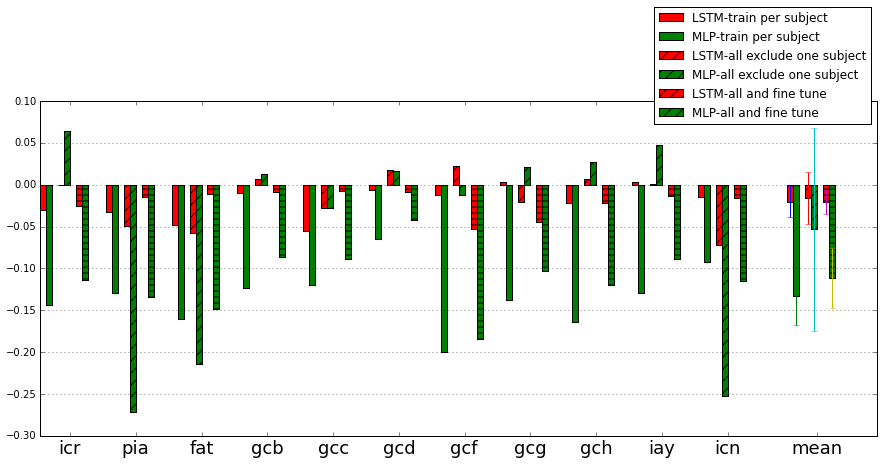

In [111]:
names = [x[0] for x in lstm_accuracy_1_j]
diff_lstm_accuracy_1 = mock_2_tuple(names, np.array([x[1] for x in lstm_accuracy_1_j]) - np.array([x[1] for x in lstm_accuracy_1]))

diff_mlp_accuracy_1 = mock_2_tuple(names,np.array([x[1] for x in mlp_accuracy_1_j]) - np.array([x[1] for x in mlp_accuracy_1]))

diff_lstm_accuracy_2 = mock_2_tuple(names, np.array([x[1] for x in lstm_accuracy_2_j]) - np.array([x[1] for x in lstm_accuracy_2]))
diff_mlp_accuracy_2 = mock_2_tuple(names, np.array([x[1] for x in mlp_accuracy_2_j]) - np.array([x[1] for x in mlp_accuracy_2]))

diff_lstm_accuracy_3 = mock_2_tuple(names, np.array([x[1] for x in lstm_accuracy_3_j]) - np.array([x[1] for x in lstm_accuracy_3]))
diff_mlp_accuracy_3 = mock_2_tuple(names, np.array([x[1] for x in mlp_accuracy_3_j]) - np.array([x[1] for x in mlp_accuracy_3]))

plot_accuracies(diff_lstm_accuracy_1, diff_mlp_accuracy_1, diff_lstm_accuracy_2, diff_mlp_accuracy_2, diff_lstm_accuracy_3, diff_mlp_accuracy_3,  
                    names=['LSTM-train per subject', 
                           'MLP-train per subject',
                           'LSTM-all exclude one subject',
                           'MLP-all exclude one subject',
                           'LSTM-all and fine tune', 
                           'MLP-all and fine tune'],loc=0)



In [162]:
import pandas as pd
import pyperclip
pd.set_option('display.precision',2)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

all_diff = np.vstack(
[np.array(np.array([x[1] for x in lstm_accuracy_1_j]) - np.array([x[1] for x in lstm_accuracy_1])),
 np.array(np.array([x[1] for x in lstm_accuracy_2_j]) - np.array([x[1] for x in lstm_accuracy_2])),
 np.array(np.array([x[1] for x in lstm_accuracy_3_j]) - np.array([x[1] for x in lstm_accuracy_3])),
 np.array(np.array([x[1] for x in mlp_accuracy_1_j]) - np.array([x[1] for x in mlp_accuracy_1])),
np.array(np.array([x[1] for x in mlp_accuracy_2_j]) - np.array([x[1] for x in mlp_accuracy_2])),
np.array(np.array([x[1] for x in mlp_accuracy_3_j]) - np.array([x[1] for x in mlp_accuracy_3]))])
# print all_diff.mean(axis=1).reshape(-1, 1)

all_diff_with_mean =np.hstack([all_diff,all_diff.mean(axis=1).reshape(6, 1)])
diff = pd.DataFrame(data=all_diff_with_mean,index=['LSTM-train per subject', 
                                         'LSTM-all exclude one subject',
                                         'LSTM-all and fine tune','MLP-train per subject',
                                                                                                                            'MLP-all exclude one subject',
                                                                                                                            'MLP-all and fine tune'],
                    columns=[x[0][-7:-4] for x in lstm_accuracy_1_j]+['mean'])
text = diff.to_latex()
pyperclip.copy(text)


In [70]:
stats.ttest_ind(lstm_ft,mlp_ft, equal_var = False)

Ttest_indResult(statistic=7.5381531597972318, pvalue=3.8325896685872968e-06)

In [51]:
, mlp_accuracy_1_j, lstm_accuracy_2_j

([0.8414814814814815,
  0.93520000000000003,
  0.92000000000000004,
  0.94793650793650797,
  0.92294117647058826,
  0.84294871794871795,
  0.73518518518518516,
  0.57141025641025645,
  0.73902777777777773,
  0.68266666666666664,
  0.86199999999999999],
 [['RSVP_Color116msVPicr.mat', 0.7659259259259259],
  ['RSVP_Color116msVPpia.mat', 0.84386666666666665],
  ['RSVP_Color116msVPfat.mat', 0.77203703703703708],
  ['RSVP_Color116msVPgcb.mat', 0.83412698412698416],
  ['RSVP_Color116msVPgcc.mat', 0.8225490196078431],
  ['RSVP_Color116msVPgcd.mat', 0.81474358974358974],
  ['RSVP_Color116msVPgcf.mat', 0.6216666666666667],
  ['RSVP_Color116msVPgcg.mat', 0.55051282051282047],
  ['RSVP_Color116msVPgch.mat', 0.6431944444444444],
  ['RSVP_Color116msVPiay.mat', 0.59799999999999998],
  ['RSVP_Color116msVPicn.mat', 0.79449999999999998]],
 [['RSVP_Color116msVPicr.mat', 0.63388888888888884],
  ['RSVP_Color116msVPpia.mat', 0.48626666666666668],
  ['RSVP_Color116msVPfat.mat', 0.74981481481481482],
  ['RSVP